In [168]:
import sys
sys.path.insert(0,'/Users/nakaa1/code/py/PsychRNN')

import psychrnn
from psychrnn.tasks import rdm as rd
from psychrnn.backend.models.basic import Basic, BasicSigmoid
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
import importlib
importlib.reload(psychrnn)

from brian2 import *

define params globally first before passing to RDM, mess w/ model params and explain what can do. (can turn on and off dale's law). some masking, input output connectivity. train_params variables stuff

In [274]:
dt = 1 # time-step
tau = 10 # intrinsic time constant of neural state decay
T = 400 # time to run for (number of steps is T/dt)
N_batch = 10 # number of trials per training step
N_rec = 80 # number of recurrent units
name = 'basicModel'
N_in = 50
N_out = 50

In [275]:
from psychrnn.tasks.task import Task

def gaussian_input(N_in, mu = 0, sigma = 1):
    y = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (np.arange(N_in) - mu)**2 / (2 * sigma**2)))
    y = y/np.max(y)
    return y

"""
Binary Decision task. 
Takes two channels of noisy input.
Binary output with a one hot encoding towards the higher mean channel
"""

class noisy_decode(Task):
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(noisy_decode,self).__init__(N_in, N_out, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.6
        params['duration'] = 500
        params['mu'] = np.random.randint(self.N_in)
        params['sigma'] = 3
        params['neuron_noise'] = 1
        params['baseline_rate'] = 10
        params['peak_rate'] = np.random.choice(20)+5
        true_rates = gaussian_input(N_in = N_in,
                                              mu = params['mu'],
                                              sigma = params['sigma']) * params['peak_rate']
        true_rates[true_rates<0.01] = 0
        params['true_rates'] = true_rates.copy()
        
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) + baseline_rate + np.random.randn(self.N_in)*params['neuron_noise']
        y_t = np.zeros(self.N_out) + baseline_rate 
         

        
        if (t>params['onset']) and (t<(params['onset']+params['duration'])):
            y_t += params['true_rates']
            x_t += params['true_rates']  

        x_t[x_t<0] = 0

        mask_t = np.ones(self.N_out)
        
        return x_t, y_t, mask_t


In [276]:
swv = noisy_decode(N_in = N_in, N_out = N_out,dt = dt, tau = tau, T = T, N_batch = N_batch)
gen = swv.batch_generator()

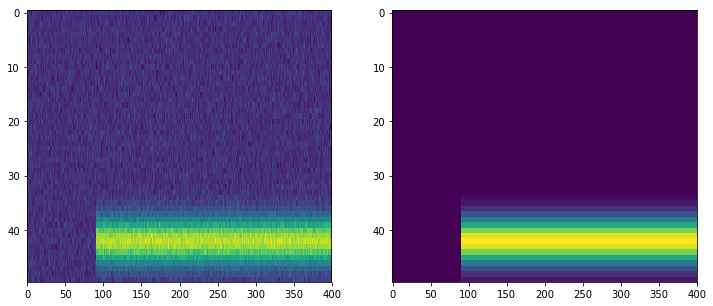

In [277]:
x,y,m = next(gen)
f,ax = plt.subplots(1,2,figsize = (12,5))
ax[0].imshow(x[0,:,:].T,aspect = 'auto')
ax[1].imshow(y[0,:,:].T,aspect = 'auto')

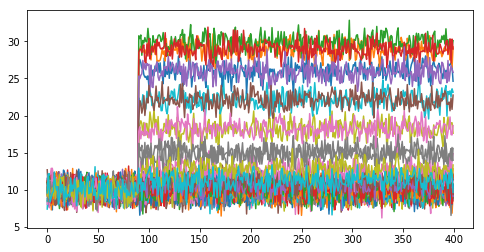

In [278]:
f,ax = plt.subplots(figsize = (8,4))
ax.plot(x[0,:,:]);
# ax.set_xlim((0,50))

In [279]:
params = swv.__dict__
print(params)

{'N_batch': 10, 'N_in': 50, 'N_out': 50, 'dt': 1, 'tau': 10, 'T': 400, 'alpha': 0.1, 'N_steps': 400}


Generate *N_batch* trials to be used in training

We add in a few params that Basic(RNN) needs but that RDM doesn't generate for us.

In [280]:
params['name'] = name #Used to scope out a namespace for global variables.
params['N_rec'] = N_rec

There are some other optional parameters we can add in:

In [281]:
params['dale_ratio'] = 0.5 # Default: None -- when the dale_ratio is set, dale's law is applied
params['rec_noise'] = 0.0 # Default: 0.0 -- how much noise to add to the new_state calculation
params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
params['b_rec_train'] = True # Indicates whether b_rec is trainable. Default: True
params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True
params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None
params['L2_out'] = 0

Instantiate our model

In [282]:
basicModel.destruct()

In [283]:
basicModel = Basic(params)

Start a tensorflow session with loss, regularization, predictions, and regularized loss defined.

In [284]:
basicModel.build()

Set the training parameters for our model. All of the parameters below are optional.

In [285]:
train_params = {}
train_params['save_weights_path'] =  '../weights/refactor_weights.npz' # Where to save the model after training. Default: None
train_params['training_iters'] = 10000 # number of iterations to train for Default: 10000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['generator_function'] = None # replaces trial_batch_generator with the generator_function when not none. Default: None
train_params['optimizer'] = tf.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True

In [286]:
train_params

{'save_weights_path': '../weights/refactor_weights.npz',
 'training_iters': 10000,
 'learning_rate': 0.001,
 'loss_epoch': 10,
 'verbosity': True,
 'save_training_weights_epoch': 100,
 'training_weights_path': None,
 'generator_function': None,
 'optimizer': <tensorflow.python.training.adam.AdamOptimizer at 0x2339b60f0>,
 'clip_grads': True}

Train our model.

In [ ]:
basicModel.train(gen, train_params)

Iter 100, Minibatch Loss= 25.963913
Iter 200, Minibatch Loss= 9.024111
Iter 300, Minibatch Loss= 18.618380
Iter 400, Minibatch Loss= 10.719518
Iter 500, Minibatch Loss= 18.095837
Iter 600, Minibatch Loss= 11.550189
Iter 700, Minibatch Loss= 12.503815
Iter 800, Minibatch Loss= 8.677944
Iter 900, Minibatch Loss= 8.602218
Iter 1000, Minibatch Loss= 7.382957
Training weights saved in file: None100
Iter 1100, Minibatch Loss= 11.036777
Iter 1200, Minibatch Loss= 10.300780
Iter 1300, Minibatch Loss= 10.268669
Iter 1400, Minibatch Loss= 5.798430
Iter 1500, Minibatch Loss= 9.255153
Iter 1600, Minibatch Loss= 7.505951
Iter 1700, Minibatch Loss= 8.353025
Iter 1800, Minibatch Loss= 5.581419
Iter 1900, Minibatch Loss= 5.025632
Iter 2000, Minibatch Loss= 4.670160
Training weights saved in file: None200
Iter 2100, Minibatch Loss= 3.522305
Iter 2200, Minibatch Loss= 4.727869
Iter 2300, Minibatch Loss= 3.296839
Iter 2400, Minibatch Loss= 4.488186
Iter 2500, Minibatch Loss= 2.529212
Iter 2600, Minibatch

### Plot results

Extract the next trial from the generator

Run the trained model on this trial (not included in the training set).

In [89]:
x,y,m = next(gen)

In [90]:
results = basicModel.test(x)
output = results[0]
state_var = results[1]

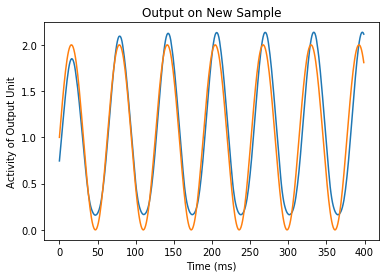

In [91]:
plt.plot(range(0, len(output[0,:,:])*dt,dt),output[0,:,:])
plt.ylabel("Activity of Output Unit")
plt.xlabel("Time (ms)")
plt.title("Output on New Sample")
plt.plot(range(0, len(y[0,:,:])*dt,dt), y[0,:,:])

In [92]:
weights = basicModel.get_weights()
E = np.diag(weights['Dale_rec'])>0
I = np.diag(weights['Dale_rec'])<0

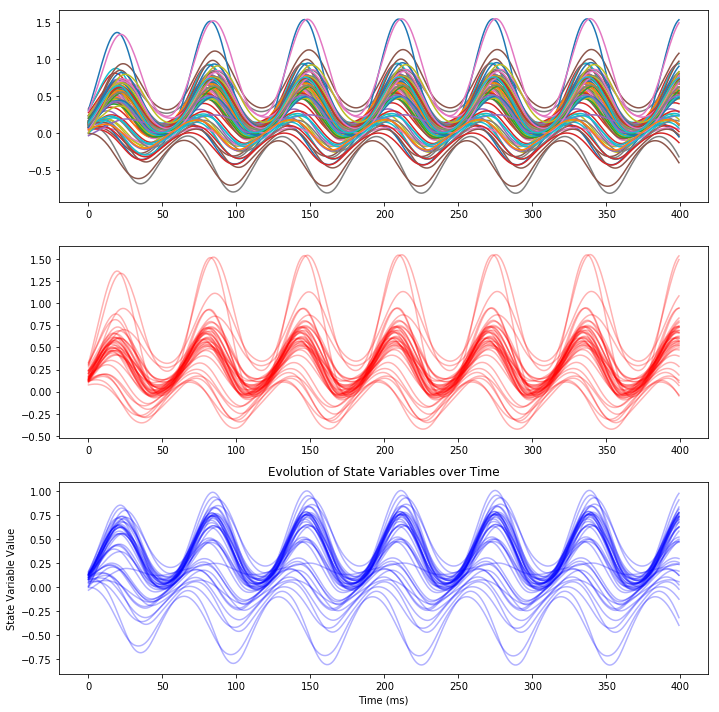

In [93]:
f,ax = plt.subplots(3,1,figsize = (10,10))

ax[0].plot(range(0, len(state_var[0,:,:])*dt,dt),state_var[0,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")

for ind in np.where(E)[0]:
    ax[1].plot(range(0, len(state_var[0,:,ind])*dt,dt),state_var[0,:,ind],'r',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")

for ind in np.where(I)[0]:
    ax[2].plot(range(0, len(state_var[0,:,ind])*dt,dt),state_var[0,:,ind],'b',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.tight_layout()

In [160]:
peak_times_first_cycle = np.argmax(state_var[0,:50,:],axis =0)

In [159]:
state_var.shape

(50, 200, 40)

In [161]:
peak_times_first_cycle

array([18, 15, 21, 22, 11, 22, 15, 16, 12, 16,  9, 15, 18, 14, 13, 16, 17,
       18, 16, 15, 15, 17, 18, 18, 20, 19, 19, 16, 24, 19,  3, 22,  3, 19,
       21, 21, 22, 20, 20, 22])

In [162]:
np.sort(peak_times_first_cycle)

array([ 3,  3,  9, 11, 12, 13, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 21, 21, 21,
       22, 22, 22, 22, 22, 24])

In [163]:
peak_order = np.argsort(peak_times_first_cycle)

In [164]:
peak_order

array([32, 30, 10,  4,  8, 14, 13, 11, 19,  6,  1, 20,  9, 27, 15, 18,  7,
       21, 16, 23, 22,  0, 17, 12, 25, 26, 29, 33, 24, 37, 38, 35,  2, 34,
       36,  3,  5, 31, 39, 28])

In [170]:
sort_state = np.zeros(state_var.shape)
for trial in range(state_var.shape[0]):
    for i,this_neuron in enumerate(peak_order):
        sort_state[trial,:,i] = state_var[trial,:,this_neuron]

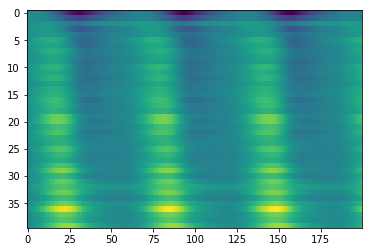

In [173]:
plt.imshow(sort_state[1,:,:].T,aspect = 'auto')

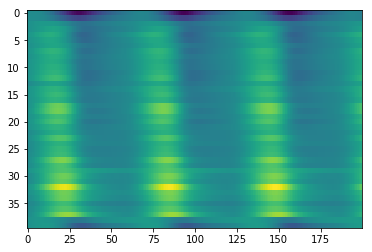

In [158]:
plt.imshow(state_var[0,:,peak_order],aspect = 'auto')

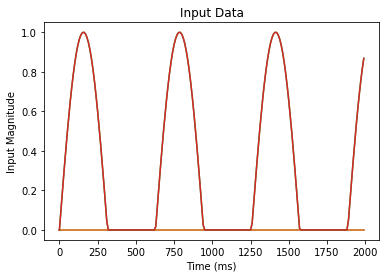

In [132]:
plt.plot(range(0, len(x[0,:,:])*dt,dt), x[0,:,:])
plt.ylabel("Input Magnitude")
plt.xlabel("Time (ms)")
plt.title("Input Data")
plt.plot(range(0, len(y[0,:,:])*dt,dt), y[0,:,:])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.], dtype=float32)

In [44]:
weights['input_connectivity'].shape

(50, 2)

In [45]:
weights.keys()
toplot = ['W_in', 'W_rec', 
 'W_out','Dale_rec', 
 'Dale_out', 'input_connectivity', 
 'rec_connectivity', 'output_connectivity']

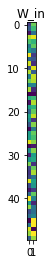

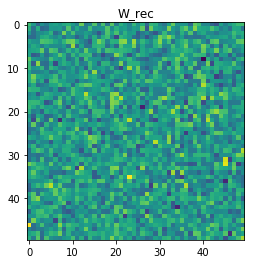

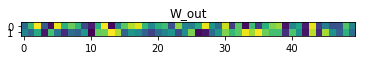

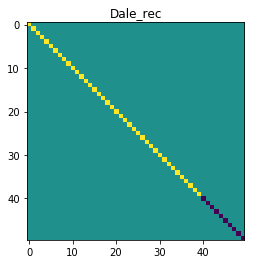

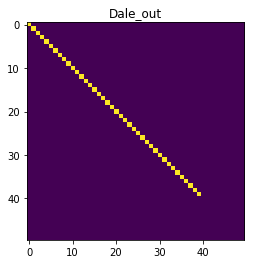

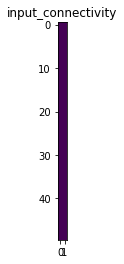

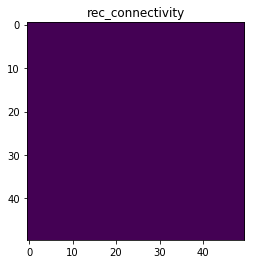

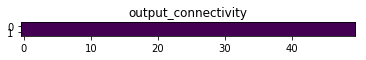

In [58]:
for key in toplot:
    plt.figure()
    plt.imshow(weights[key])
    plt.title(key)

Text(0.5, 1.0, 'Output on New Sample')

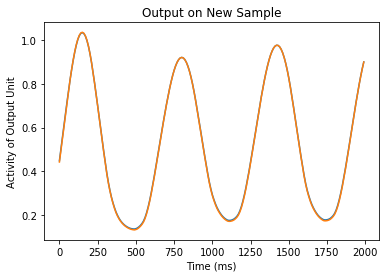

In [63]:
N_rec = 10
dale_ratio = 0.8

In [64]:
dale_vec = np.ones(N_rec)
        
dale_vec[int(dale_ratio * N_rec):] = -1
dale_rec = np.diag(dale_vec)
dale_vec[int(dale_ratio * N_rec):] = 0
dale_out = np.diag(dale_vec)

In [65]:
dale_rec

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

Text(0.5, 1.0, 'Evolution of State Variables over Time')

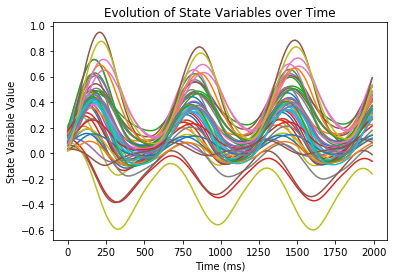

Clean up the model to clear out the tensorflow namespace

In [122]:
basicModel.destruct()

In [ ]:
def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,T,dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins
    
def uniform_psth():
        time_bins = np.arange(0,T,dt)
        psth = np.ones(time_bins.shape)*dt/second
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind    

def diff_of_exps(x_range,tau_rise = 1,tau_decay = 3, onset = 0):
    y = np.zeros(x_range.shape)
    for i,x in enumerate(x_range):
        y[i] = (1/np.exp((x-onset)/tau_decay)) - (1/np.exp((x-onset)/tau_rise))
    y[y<0] = 0
    return y 
#     onset_time = int(kernel_length*onset)
alpha_k = diff_of_exps(np.arange(30),tau_rise = 0.1,tau_decay = 3, onset = 14)   
plt.plot(np.arange(30),alpha_k)